In [7]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [8]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY is missing in your .env")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [9]:
from langchain_openai import ChatOpenAI

In [10]:
chat_llm = ChatOpenAI(model="gpt-4o-mini")

In [11]:
chat_llm.invoke("Hello, how are you?").content

"Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [12]:
from typing_extensions import TypedDict, Annotated
import operator

In [13]:
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

In [14]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [15]:
def llm_call(state: GraphState) -> dict:
    """Call the LLM using conversation messages and append AI Response"""
    response = chat_llm.invoke(state["messages"]) # AI Message
    return {
		"messages": [response]
	}

In [16]:
def token_counter(state: GraphState) -> dict:
    """Count token (simple word count) in the last AI Message"""
    last_msg = state["messages"][-1]
    text = last_msg.content
    token_number = len(text.split())
    summary = f"Total token number in the generated answer (word count) is {token_number}"
    return {
		"messages": [AIMessage(content=summary)]
	}

In [17]:
from langgraph.graph import StateGraph

In [18]:
builder = StateGraph(GraphState)

In [19]:
builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [20]:
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [21]:
app = builder.compile()

In [22]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

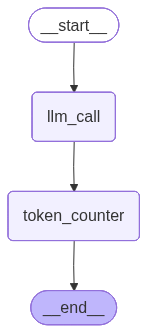

In [23]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
result = app.invoke({
	"messages": [HumanMessage(content="Hi, I am Erik. Say hi to all in 1 line.")]
})
result

{'messages': [HumanMessage(content='Hi, I am Erik. Say hi to all in 1 line.', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hi everyone, I'm Erik!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 22, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_373a14eb6f', 'id': 'chatcmpl-DANLA4H6yqLK6Xy5cK0kTtxZGwshI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c6d9c-2a3f-7872-9e7a-85319efe0c18-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 22, 'output_tokens': 6, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'rea

In [25]:
for m in result["messages"]:
    print(type(m).__name__, ":", m.content)

HumanMessage : Hi, I am Erik. Say hi to all in 1 line.
AIMessage : Hi everyone, I'm Erik!
AIMessage : Total token number in the generated answer (word count) is 4


In [26]:
chat_llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'text_inputs': True, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'text_outputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x000001C3DE5B7380>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001C3DE5B7E00>, root_client=<openai.OpenAI object at 0x000001C3DE5B4AD0>, root_async_client=<openai.AsyncOpenAI object at 0x000001C3DE5B7B60>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [27]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [28]:
api_wrapper = WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=1000)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [29]:
wiki_tool.run({"query": "What is classic literature"})

'Page: Classic book\nSummary: A classic is a book accepted as being exemplary or particularly noteworthy, usually of some chronological age since its original publications. What makes a book "classic" is a concern that has occurred to various authors ranging from Italo Calvino to Mark Twain and the related questions of "Why Read the Classics?" and "What Is a Classic?" have been essayed by authors from different genres and eras (including Calvino, T. S. Eliot, Charles Augustin Sainte-Beuve). The ability of a classic book to be reinterpreted, re-translated, abridged and parodied, to seemingly be renewed in the interests of generations of readers succeeding its creation, is a theme that is seen in the writings of literary critics including Michael Dirda, Ezra Pound, and Sainte-Beuve. These books can be published as a collection such as Great Books of the Western World, Modern Library, or Penguin Classics, debated, as in the Great American Novel, or presented as a list, such as Harold Bloo

In [30]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [31]:
TAVILY_API_KEY

'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'

In [32]:
tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

C:\Users\Erkinbek\AppData\Local\Temp\ipykernel_3828\1068719361.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


In [33]:
tool.invoke({"query": "What is React?"})

[{'title': 'React (software) - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/React_(software)',
  'content': 'React (also known as React.js or ReactJS) is a free and open-source front-end JavaScript library that aims to make building user interfaces based on components more "seamless". It is maintained by Meta (formerly Facebook) and a community of individual developers and companies. According to the 2025 Stack Overflow Developer Survey, React is one of the most commonly used web technologies. [...] React can be used to develop single-page, mobile, or server-rendered applications with frameworks like Next.js and React Router. Because React is only concerned with the user interface and rendering components to the DOM, React applications often rely on libraries for routing and other client-side functionality. A key advantage of React is that it only re-renders those parts of the page that have changed, avoiding unnecessary re-rendering of unchanged DOM elements. React is used by a

In [34]:
from langchain_community.tools import DuckDuckGoSearchRun
search=DuckDuckGoSearchRun()

In [35]:
search.invoke("What is latest Iphone price with 256GB?")

Impersonate 'firefox_117' does not exist, using 'random'


"September 4, 2025 - ... From the article: Apple's upcoming iPhone 17 Air will have a $1,099 starting price providing 256GB of base storage and will max out at $1,499 with a 1TB option, according to the latest TrendForce report. September 9, 2025 - The 6A (or really the updated to Android that came with it) drove me to get an iPhone. ... I'm currently using a pixel (6) and am likely upgrading to the base iphone 17 (The price for 256gb absolutely is a factor... September 9, 2025 - Model Storage Price (USD) iPhone 17 iPhone Air iPhone 17 Pro iPhone 17 Pro Max The iPhone 17 Pro begins at $1,099 for the 256GB model, while the larger Pro Max starts at $1,199 with the same storage. 1 month ago - The iPhone 17 packs an A19 chip, an upgrade from the A18 chip in the iPhone 16. One key difference is that the iPhone 17 starts at 256GB, while the iPhone 16 started at 128GB for the same $829 price when it debuted. 1 month ago - That doesn't mean there aren't tradeoffs, which feel especially weighty

In [36]:
import os
from dotenv import load_dotenv
load_dotenv()
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
print(os.getenv("SERPER_API_KEY"))

d9b1bbde9b55b439b446da4c03d94b2a388851e295e77a40f4065b781468e370


In [37]:
from langchain_community.utilities import GoogleSerperAPIWrapper
search = GoogleSerperAPIWrapper(serper_api_key=SERPER_API_KEY)

In [38]:
from langchain_community.tools import YouTubeSearchTool
tool = YouTubeSearchTool()
tool.name
tool.description

'search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional'

In [39]:
tool.run("chillmusic")

"['https://www.youtube.com/watch?v=sF80I-TQiW0&pp=ygUKY2hpbGxtdXNpYw%3D%3D', 'https://www.youtube.com/watch?v=IuzD5J87QFc&list=RDIuzD5J87QFc&start_radio=1&pp=ygUKY2hpbGxtdXNpY6AHAQ%3D%3D']"

In [40]:
# How to create a custom tool(function) with the help of decorator
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """this tool is for the multiplication"""
    return a * b
multiply.invoke({ "a": 10, "b": 20 })

200

In [41]:
# Create a function
@tool
def get_word_length(word:str) -> int:
    """it is function to count the length of the word"""
    return len(word)

get_word_length.invoke("hello world")

11

In [42]:
get_word_length.invoke({"word": "hello world"})

11

In [43]:
@tool
def call_gmail_api(args):
    """this is a tool to call gmail api"""
    pass

In [44]:
@tool

def call_sqllite_db(args):
    """this is a tool to call gmailapi"""
    pass

get_word_length.invoke("hello world")
get_word_length.invoke({"word": "hello world"})

11

In [ ]:
import yfinance as yf

@tool
def get_stock_price(ticker: str) -> str:
    """this is a tool to get stock price using yfinance"""
    try:
        stock = yf.Ticker(ticker)

        # Get the last 1 day historical data
        data = stock.history(period="id")

        if data.empty:
            return f"No data found for ticker {'ticker'}. Please check the symbol."
        latest_close = data["Close"].iloc[-1]

        # Detect currency
        currency = stock.info.get("currency", "")
        symbol_map = {
			"USD": "$",
			"EUR": "€",
            "GBR": "£"
		}
        
        symbol = symbol_map.get(currency, "")
        currency_text = currency if currency else ""

        if symbol:
            return f"The last closing price of {ticker.upper()} was {symbol}{latest_close:.2f}."
        else:
            return f"The last closing price of {ticker.upper()} was {latest_close:.2f} {currency_text}"
    except Exception as e:
        return f"An error occured while fetching stock data: {str(e)}"

In [46]:
get_stock_price.invoke("TCS.NS")

TCS.NS: Period 'id' is invalid, must be one of: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max


'No data found for ticker ticker. Please check the symbol.'

In [ ]:
get_stock_price.invoke("AAPL")

In [ ]:
[get_stock_price,get_word_length,multiply]

In [50]:
tools = [get_stock_price,get_word_length,multiply,wiki_tool]

In [62]:
chat_llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'text_inputs': True, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'text_outputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x000001C3DE5B7380>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001C3DE5B7E00>, root_client=<openai.OpenAI object at 0x000001C3DE5B4AD0>, root_async_client=<openai.AsyncOpenAI object at 0x000001C3DE5B7B60>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [74]:
llm_with_tools=chat_llm.bind_tools(tools)

In [ ]:
result = llm_with_tools.invoke("What is stock price")

In [75]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [ ]:
SYSTEM_PROMPT = SystemMessage(content="You are a helpful assistant that can use tools to answer question")

In [ ]:
def function_1(state: MessagesState):
    user_question=state["messages"]
    input_question = [SYSTEM_PROMPT] + user_question
    response = llm_with_tools.invoke(input_question)

    return{
        "messages": [response]
    }

In [77]:
tools
function_2 = ToolNode(tools)

In [78]:
workflow = StateGraph(MessagesState)

In [79]:
workflow.add_node("llm", function_1)

In [80]:
workflow.add_node("tools", function_2)

In [81]:
workflow.add_edge(START, "llm")

In [82]:
workflow.add_conditional_edges(
	"llm",
	tools_condition
)

In [83]:
workflow.add_edge("tools", "llm")

In [84]:
app = workflow.compile()

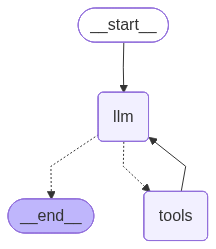

In [85]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [86]:
result = app.invoke({
	"messages": [HumanMessage(content="what is the stock for Nvidia?")]
})

NVDA: Period 'id' is invalid, must be one of: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: NVIDIA"}}}
$NVIDIA: possibly delisted; no price data found  (period=id) (Yahoo error = "No data found, symbol may be delisted")


In [87]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the stock for Nvidia?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_gBTAwlRI6MiQcMP3cs4eduQu)
 Call ID: call_gBTAwlRI6MiQcMP3cs4eduQu
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

No data found for ticker ticker. Please check the symbol.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_ZLHGN4m9cIUSayrBFCbHLXw0)
 Call ID: call_ZLHGN4m9cIUSayrBFCbHLXw0
  Args:
    ticker: NVIDIA
================================= Tool Message =================================
Name: get_stock_price

No data found for ticker ticker. Please check the symbol.
================================== Ai Message ==================================

It appears there was an issue retrieving the stock price for Nvi

In [88]:
result = app.invoke({
	"messages": [HumanMessage(content="what is final budget of Tesla for 2025?")]
})

In [89]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

what is final budget of Tesla for 2025?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_U7gTvs8C1vf73HAapD5IqoU5)
 Call ID: call_U7gTvs8C1vf73HAapD5IqoU5
  Args:
    query: Tesla budget 2025
================================= Tool Message =================================
Name: wikipedia

Page: Tesla Model Y
Summary: The Tesla Model Y is a battery electric compact crossover SUV produced by Tesla, Inc. since 2020. Presented in March 2019 as the company's fifth production model, the Model Y is the best-selling electric vehicle of all time, having sold more than 2.16 million units worldwide.
After its 2019 introduction, the Model Y started production at the Tesla Fremont Factory in California, US in January 2020. Production at Giga Shanghai, China was added in December 2020, and at Gigafactory Texas, US since late 2021. Deliveries from Gigafactory

In [90]:
result = app.invoke({
	"messages": [HumanMessage(content="what is latest AI News?")]
})
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

what is latest AI News?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_VBxBqtdBAeLfkn9GFgIsWqQr)
 Call ID: call_VBxBqtdBAeLfkn9GFgIsWqQr
  Args:
    query: Latest AI news
================================= Tool Message =================================
Name: wikipedia

Page: Mistral AI
Summary: Mistral AI SAS (French: [mistʁal]) is a French artificial intelligence (AI) company, headquartered in Paris. Founded in 2023, it has open-weight large language models (LLMs), with both open-source and proprietary AI models. As of 2025 the company has a valuation of more than US$14 billion.



Page: AI slop
Summary: AI slop (known simply as slop) is digital content made with generative artificial intelligence that is lacking in effort, quality, or meaning, and produced in high volume as clickbait to gain advantage in the attention economy, or earn money.